Generate sample paths

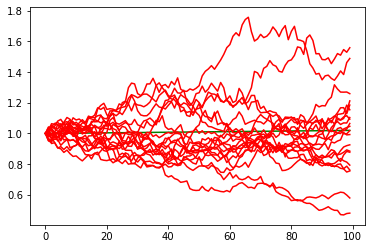

In [52]:
import math
import numpy as np
import matplotlib.pyplot as plt

T = 1.0
nb_simu = 5000
nb_time = 100
nb_underlyings = 5
nb_stoch_factors = 3

dt = T / float(nb_time)
dt_sqrt = math.sqrt(dt)
dW_t = np.random.normal(size=(nb_simu,nb_time,nb_stoch_factors)) * dt_sqrt

r = .02

sigma = np.array([[.1, .2, .15], [.2, .3, .35], [.35, .1, .2], [.1, .25, .3], [.1, .1, .15]])
mu = np.array([.01, .02, .015, .02, .015])

cov = np.dot(sigma, sigma.transpose())

S = np.zeros((nb_simu, nb_time, nb_underlyings))
t = np.arange(0, T, dt)

S0 = 1.0

B = np.exp(r * t)
plt.plot(B, color='green')

for i in range(0, nb_simu):
    for j in range(0, nb_underlyings):
        S[i][0][j] = S0
  
for i in range(0, nb_simu):
    for j in range(1, nb_time):
        for k in range(0, nb_underlyings):
            dZ_t = .0
            
            for l in range(0, nb_stoch_factors):
                dZ_t += sigma[k,l] * dW_t[i,j,l]
            
            S[i][j][k] = S[i][j-1][k] * (1.0 + mu[k] * dt + dZ_t)

        
for i in range(0, 20):
    plt.plot(S[i,:,0], color='red')
    
plt.show()

Retrieve stochastic factors

[-0.0246641  -0.10280447 -0.06850407 -0.05822039 -0.00448425] [-0.02625 -0.10625 -0.07125 -0.06125 -0.00625]


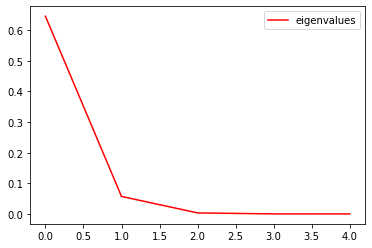

[6.45860840e-01 5.71323090e-02 3.31619727e-03 2.58451046e-05
 1.18462295e-06]


In [49]:
from numpy import linalg

log_returns = np.zeros((nb_simu, nb_time-1, nb_underlyings))

for i in range(0, nb_time-1):
    log_returns[:,i,:] = np.log(np.divide(S[:,i+1,:], S[:,i,:]))
                                
log_returns0 = np.zeros((nb_simu*(nb_time-1), nb_underlyings))
                                
for i in range(0, nb_time-1):  
    for j in range(0, nb_simu): 
         log_returns0[j+i*nb_simu] = log_returns[j,i,:]                  
                                
cov_emp = np.cov(log_returns0.T) / dt 

#print(cov, cov_emp)

mu_emp = np.mean(log_returns0, axis=0) / dt
mu_theo = np.array([mu[i] - .5 * np.sum(np.array([sigma[i,k] ** 2 for k in range(0, nb_stoch_factors)])) for i in range(0, nb_underlyings)])

print(mu_emp, mu_theo)

eigen_values, eigen_vectors = linalg.eig(cov_emp)

eigen = [(eigen_value, eigen_vectors[:,i]) for i, eigen_value in enumerate(eigen_values)]
eigen.sort(key=lambda pair: pair[0], reverse=True)

eigen_values, eigen_vectors = np.array([_eigen[0] for _eigen in eigen]), np.array([_eigen[1] for _eigen in eigen])

plt.plot(eigen_values, color='red', label='eigenvalues')
plt.legend()
plt.show()

print(eigen_values)

#for i in range(0, nb_underlyings):
#    print(cov_emp.dot(eigen_vectors[i]) - eigen_vectors[i] * eigen_values[i])

#print(np.dot(eigen_vectors.T, eigen_vectors))

L = np.zeros((nb_underlyings,nb_underlyings))

for i in range(0, nb_underlyings):
    L[i,i] = math.sqrt(eigen_values[i])

sigma_emp = np.dot(L, eigen_vectors)

#print(np.dot(sigma_emp.T, sigma_emp), cov_emp)



Create arbitrage portfolio

In [78]:
from numpy.linalg import inv
from numpy.linalg import matrix_rank

excess_return = +.05
beta = np.zeros((1+nb_stoch_factors))
beta[0] = excess_return

A = np.zeros((1+nb_stoch_factors,nb_underlyings))

for i in range(0, nb_underlyings):
    A[0,i] = mu[i] - r

for k in range(0, nb_stoch_factors):
    A[k+1,:] = sigma.T[k]

print(A)

rank_A = matrix_rank(A)
print(rank_Beta)

# compute pseudo inverse to find portfolio aggregation which yields the desired excess of return
A_inv = np.dot(A.T, inv(np.dot(A, A.T)))

#print(np.dot(A, A_inv))

u0 = np.dot(A_inv, beta)
b0 = 1 - np.sum(u0)
print("u0: " + str(u0))

#print(beta, np.dot(A, u0))

[[-0.01   0.    -0.005  0.    -0.005]
 [ 0.1    0.2    0.35   0.1    0.1  ]
 [ 0.2    0.3    0.1    0.25   0.1  ]
 [ 0.15   0.35   0.2    0.3    0.15 ]]
4
u0: [-2.14821764  3.81801126  0.31894934 -0.58161351 -6.02251407]


Roll out portfolio with excess of return

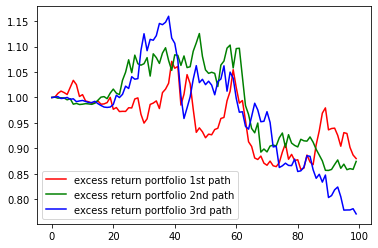

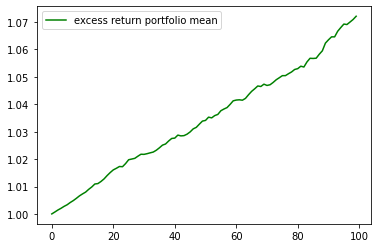

In [79]:
V = np.zeros((nb_simu, nb_time))

for i in range(0, nb_simu):
    V[i,0] = np.dot(u0, S[i,0,:]) + b0*B[0]
 
for i in range(1, nb_time): 
    for j in range(0, nb_simu):
        V[j,i] = np.dot(u0, S[j,i,:]) + b0*B[i]
 
plt.plot(V[0,:], color='red', label='excess return portfolio 1st path')
plt.plot(V[1,:], color='green', label='excess return portfolio 2nd path')
plt.plot(V[2,:], color='blue', label='excess return portfolio 3rd path')
plt.legend()
plt.show()

V_mean = np.mean(V, axis=0)

plt.plot(V_mean, color='green', label='excess return portfolio mean')
plt.legend()
plt.show()